In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# Import the TESS PRF modelling from DAVE
import numpy as np
import sys
sys.path
sys.path.append('./dave/diffimg/')
import tessprf as prf

In [3]:
def testRowFrac(datapath):        
    """Test that changing column fraction moves flux around"""

    obj = prf.TessPrf(datapath)
    
    img1 = obj.getPrfAtColRow(123.0, 456, 1,1,1)
    
    for frac in np.linspace(0, .9, 11):
        img2 = obj.getPrfAtColRow(123.0, 456.0 + frac, 1,1,1)
        delta = img2 - img1
        
        prfPlot(img1, delta)
        
        #For TESS, PRFs are 13x13. Check the flux near the centre
        #is moving from lower columns to higher ones
        assert delta[6,6] >= 0, delta[6,6]
        assert delta[7,6] >= 0, delta[7,6]
        assert delta[5,6] <= 0, delta[5,6]

        
def prfPlot(refImg, delta):
        
        kwargs = {'origin':'bottom', 'interpolation':'nearest', 'cmap':plt.cm.YlGnBu_r}
        plt.clf()
        plt.subplot(121)
        plt.imshow(refImg, **kwargs)
        plt.colorbar()
        
        plt.subplot(122)
        kwargs['cmap'] = plt.cm.PiYG
        plt.imshow(delta, **kwargs)  
        vm = max( np.fabs( [np.min(delta), np.max(delta)] ))
#        vm = 1e-2
        plt.clim(-vm, vm)
        plt.colorbar()
        plt.pause(.1)

In [4]:
pathToMatFile = './data/prf/'

<IPython.core.display.Javascript object>


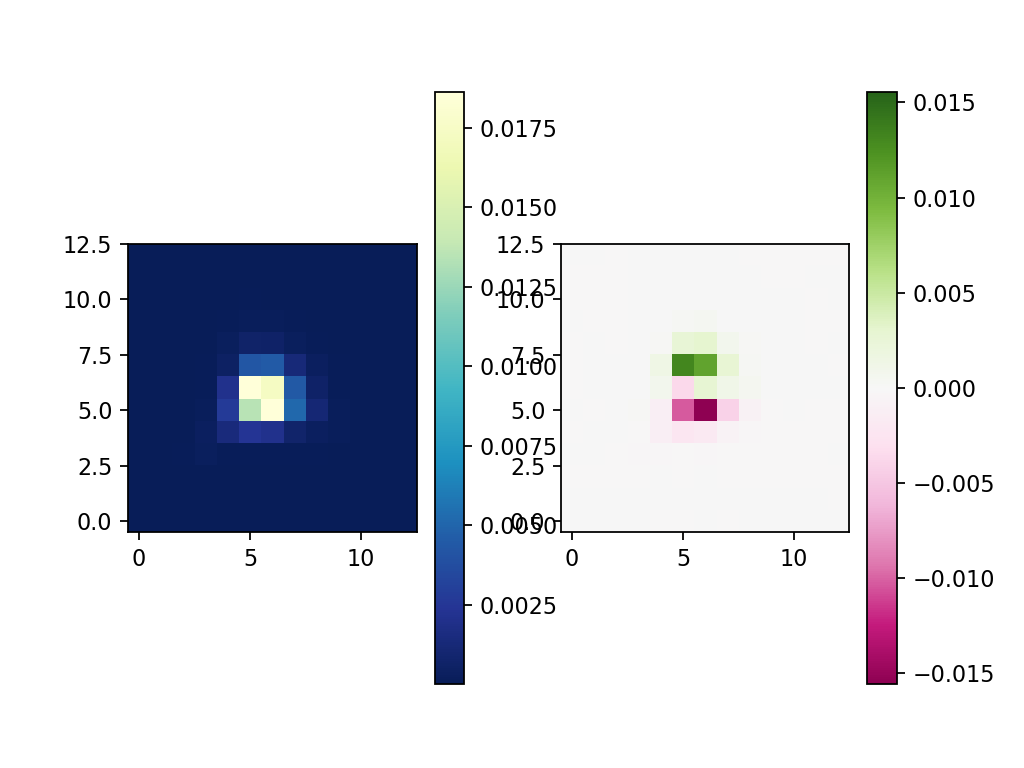

In [5]:
testRowFrac(pathToMatFile)

<IPython.core.display.Javascript object>


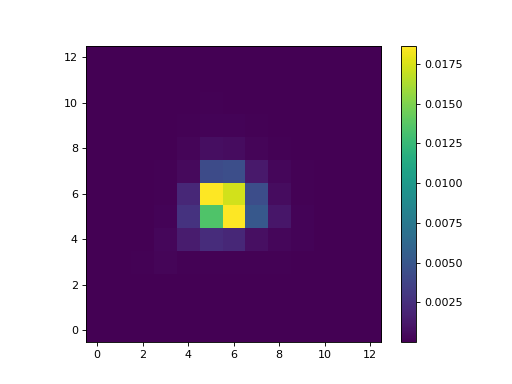

In [5]:
obj = prf.TessPrf(pathToMatFile)
img1 = obj.getPrfAtColRow(123.0, 456, 1,1,1)
plt.figure()
plt.imshow(img1,origin='lower')
plt.colorbar()

In [6]:
from scipy import signal
from scipy import interpolate

In [24]:
def Interp_PRF(X,Y,Camera,CCD):
    pathToMatFile = './data/prf/'
    obj = prf.TessPrf(pathToMatFile)
    PRF = obj.getPrfAtColRow(123.0, 456, 1,Camera,CCD)
    x2 = np.arange(0,PRF.shape[1]-1,0.01075)
    y2 = np.arange(0,PRF.shape[0]-1,0.01075)

    x = np.arange(0,PRF.shape[1],1)
    y = np.arange(0,PRF.shape[0],1)
    X, Y = np.meshgrid(x,y)

    x=X.ravel()              #Flat input into 1d vector
    y=Y.ravel()

    z = PRF
    z = z.ravel()
    x = list(x[np.isfinite(z)])
    y = list(y[np.isfinite(z)])
    z = list(z[np.isfinite(z)])

    znew = interpolate.griddata((x, y), z, (x2[None,:], y2[:,None]), method='cubic')
    kernal = znew
    return kernal

<IPython.core.display.Javascript object>


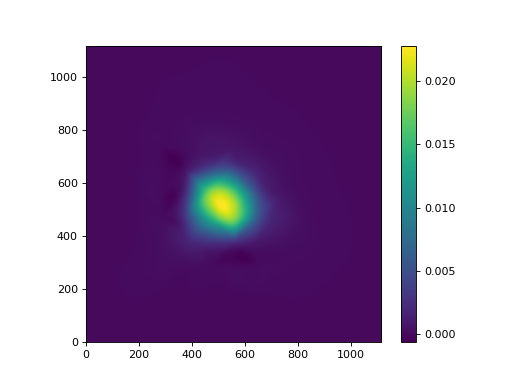

In [8]:
plt.figure()
plt.imshow(Interp_PRF(100,200,1,2),origin='lower')
plt.colorbar()

In [14]:
kernal = Interp_PRF(100,200,1,2)

<IPython.core.display.Javascript object>


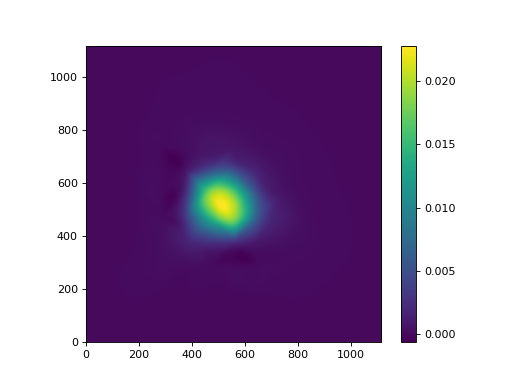

In [15]:
plt.figure()
plt.imshow(kernal,origin='lower')
plt.colorbar()
plt.savefig('TESS_psf.pdf')

In [9]:
import numpy as np
from scipy import ndimage

def block_mean(ar, fact):
    assert isinstance(fact, int), type(fact)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    regions = sy/fact * (X/fact) + Y/fact
    res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
    res.shape = (sx/fact, sy/fact)
    return res

In [10]:
plt.figure()
plt.imshow(block_mean(Interp_PRF(100,200,1,2),int(2)),origin='lower')
plt.colorbar()

<IPython.core.display.Javascript object>

TypeError: 'float' object cannot be interpreted as an integer

In [11]:
from glob import glob
from astropy.io import fits
from astropy.wcs import WCS

In [12]:
def Get_TESS_image(Path, Sector, Camera, CCD, Time = None):
    """
    Grabs a TESS FFI image from a directed path.
    Inputs
    ------
    Path: str
        Path to FFIs
    Sector: int
        Sector of the FFI
    Camera: int
        Camera of the FFI
    CCD: int
        CCD of the FFI
        
    Returns
    -------
    tess_image: array
        TESS image
    tess_wcs
        WCS of the TESS image
        
    Raises
    ------
    FileExistsError
        The file specified by the parameters does not exist.
        
    """
    if Time == None:
        File = "{Path}tess*-s{Sec:04d}-{Camera}-{CCD}*.fits".format(Path = Path, Sec = Sector, Camera = Camera, CCD = CCD)
    else:
        File = "{Path}tess{Time}-s{Sec:04d}-{Camera}-{CCD}*.fits".format(Path = Path, Time = Time, Sec = Sector, Camera = Camera, CCD = CCD)

    file = glob(File)
    if len(file) > 0:
        if (len(file) > 1):
            file = file[0]
        tess_hdu = fits.open(file)
        tess_wcs = WCS(tess_hdu[1].header)
        tess_image = tess_hdu[1].data
        return tess_image, tess_wcs
    else:
        raise FileExistsError("TESS file does not exist: '{}'".format(File))
        pass
        

In [13]:
tess_image, tess_wcs = Get_TESS_image('/Users/ryanr/Documents/PhD/coding/TPR/data/',2,1,2)

In [14]:
print(tess_image.shape[0]/2,tess_image.shape[1]/2)

1039.0 1068.0


In [15]:
ra, dec = tess_wcs.all_pix2world(1068,1039,1)
print(ra,dec)

1.220436048264915 -25.801466529257613


In [16]:
from PS_image_download import *

In [17]:
size = 1000
fitsurl = geturl(ra, dec, size=size, filters="i", format="fits")
fh = fits.open(fitsurl[0])

In [18]:
ps = fh[0].data#[1000:7000,2200:7600]

In [19]:
ps.shape

(1000, 1000)

<IPython.core.display.Javascript object>


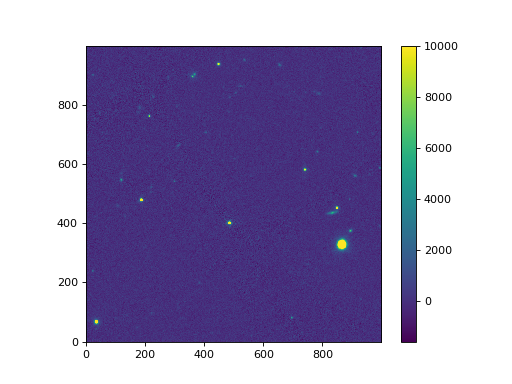

In [20]:
plt.figure()
plt.imshow(ps,vmax=10000,origin='lower')
plt.colorbar()
#plt.ylim(1000,7000)
#plt.xlim(2200,7600)

In [22]:
from scipy.ndimage.filters import convolve
from scipy.signal import fftconvolve

In [25]:
kernal = Interp_PRF(100,200,1,2)
test = fftconvolve(ps,kernal)

In [ ]:
fh[0].header

In [33]:
testps = np.copy(ps)

In [34]:
#testps[500:,600:] = 0
#testps[:300,:400] = 0

<IPython.core.display.Javascript object>


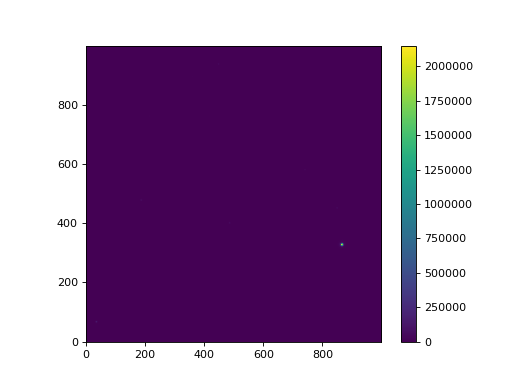

In [36]:
plt.figure()
plt.imshow(testps,origin='lower')
plt.colorbar()

In [ ]:
test = convolve(testps,kernal)

In [ ]:
plt.figure()
plt.imshow(test,origin='lower')
plt.colorbar()

In [17]:
import pandas as pd

In [24]:
pd.read_csv('/Users/ryanr/Desktop/counts.csv').values[-1,0]

'tess2018206045859-s0001-0000000029281750-0120-s_tp.fits'

In [5]:
size = 1000

In [8]:
fitsurl = geturl(319.48328631886477, -41.038304410317004, size=size, filters="i", format="fits")
fh = fits.open(fitsurl[0])

IndexError: list index out of range

In [7]:
from test_convolution import *
#%matplotlib notebook

(11.888002,-25.28822)


/Users/ryanr/anaconda3/lib/python3.5/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


'Convolved'

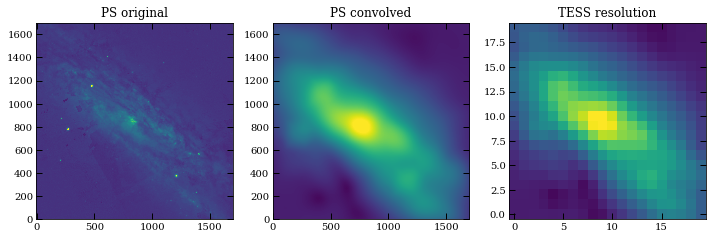

In [11]:
Run_convolution_PS(11.888002, -25.288220,1,1,PSsize=1700,Downsamp=True,Plot=True)

(1.220436048264915,-25.801466529257613)


<IPython.core.display.Javascript object>


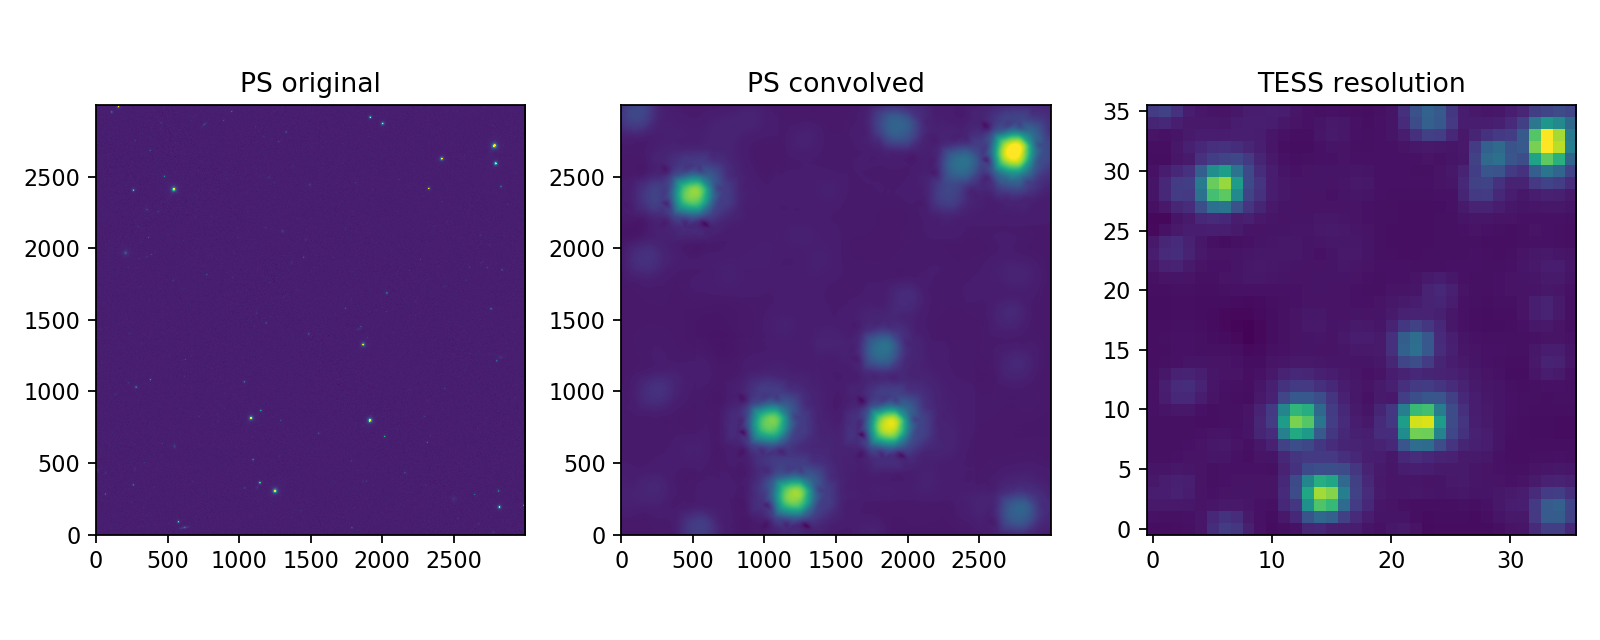

'Convolved'

In [10]:
Run_convolution('./data/',2,1,2,Plot=True,PSsize=3000,Downsamp=True)

<IPython.core.display.Javascript object>


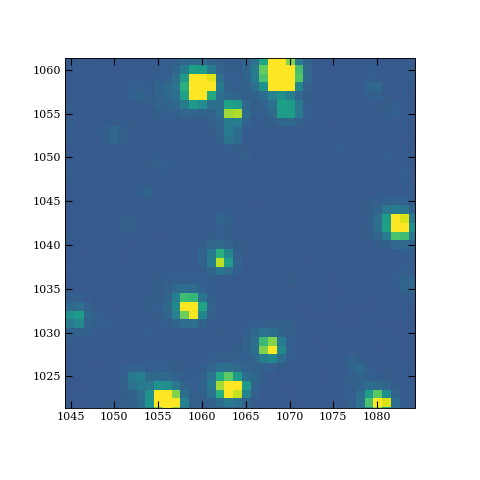

(1048, 1088)

In [27]:
plt.figure()
plt.imshow(tess_image,vmax=500,origin='lower')
plt.ylim(1039-20,1039+20)
plt.xlim(1068-20,1068+20)

In [15]:
data.shape

(1245, 35, 35)

In [23]:
tess_image, tess_wcs = Get_TESS_image('./data/',2,1,2)

In [20]:
tess_wcs.all_world2pix(1.220436048264915,-25.801466529257613,1)

[array(1068.), array(1039.00000002)]

<IPython.core.display.Javascript object>


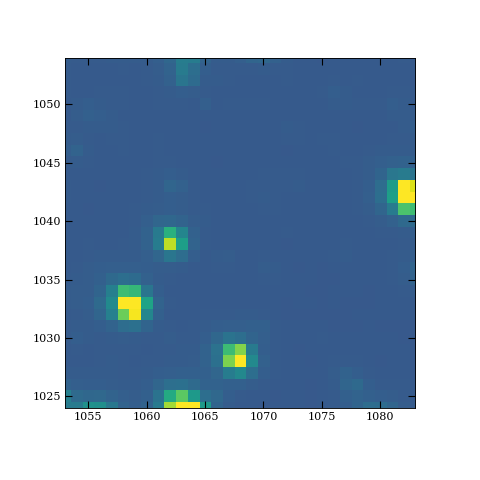

(1053, 1083)

In [26]:
plt.figure()
plt.imshow(tess_image,vmax=500,origin='lower')
plt.ylim(1039-15,1039+15)
plt.xlim(1068-15,1068+15)

In [20]:
test1 = Interp_PRF(50,50,1,1)
test2 = Interp_PRF(80,80,4,4)

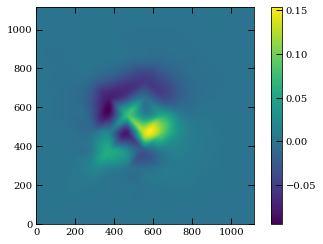

In [21]:
plt.figure()
plt.imshow((test1-test2)/np.nanmax(test1),origin='lower')
plt.colorbar()

In [9]:
np.nanmax(test1)

2.6622952186644255e-06

In [24]:
tess_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 1.2049088954883924  -26.0576271210793  
CRPIX : 1045.0  1001.0  
CD1_1 CD1_2  : 0.004994597158881548  -0.002654102364745  
CD2_1 CD2_2  : 0.002780210987902541  0.005056177352553207  
NAXIS : 2136  2078

In [25]:
fitsurl = geturl(0, 0, size=1000, filters="i", format="fits")
if len(fitsurl) > 0:
    fh = fits.open(fitsurl[0])

In [27]:
WCS(fh[0].header)

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 0.0  -1.99999999999994  
CRPIX : 501.0  -28311.0  
PC1_1 PC1_2  : -1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 6.94444461259988e-05  6.94444461259988e-05  
NAXIS : 1000  1000